<a href="https://colab.research.google.com/github/margaretmz/GANs-in-Art-and-Design/blob/main/3_dcgan_color_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

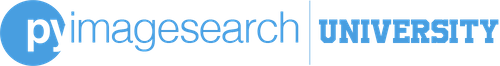

# GAN Training Challenges: DCGAN for Color Images
Author: Margaret Maynard-Reid ([@margaretmz](https://twitter.com/margaretmz))

This Colab notebook is a DCGAN implemntation with TensorFlow 2/ Keras, trained to generate 64x64 color images that resemble Zalando fashion products. It is associated with the [GAN Training Challenges: DCGAN for Color Images](https://www.pyimagesearch.com/2021/12/13/gan-training-challenges-dcgan-for-color-images/) blog post published on 2021-12-13, as part of the [PyImageSearch University](https://www.pyimagesearch.com/pyimagesearch-university/) GAN series. 

You may find all the GANs Colab notebooks in the author's GitHub repo [here](https://github.com/margaretmz/GANs-in-Art-and-Design).

Here are some helpful resources in case if you are unfamiliar with Jupyter notebooks or Colab:
*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 
  
---  
  
**Copyright:**   
The content of this notebook is licensed under a [Creative Commons Attribution-NonCommercial 4.0](https://creativecommons.org/licenses/by-nc/4.0/) license, which means you are free to share and adapt the code, under the condition that you give appropriate credit to the author and you may not use it for commercial purposes.
  

Table of Contents

>[GAN Training Challenges: DCGAN for Color Images](#scrollTo=LgNY4Ko8sw7q)

>>[Import](#scrollTo=wcrOk6pURp50)

>>[Data](#scrollTo=Mhp9hUESy46A)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The Generator](#scrollTo=BY-sz-IFbWr7)

>>[The Discriminator](#scrollTo=9qAUg0qNbXpS)

>>[DCGAN](#scrollTo=X0IOiEj-QNXd)

>>>[Define the DCGAN class](#scrollTo=urgSpXaPQlKk)

>>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>>[The DCGAN model - putting it together](#scrollTo=FzjTO5ZqRLVY)

>>[Compile DCGAN](#scrollTo=9OubidSS_Lrl)

>>[Train DCGAN](#scrollTo=1WhnM4ptN2rp)



## Import

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Its always a good practice to check the current version of TensorFlow...

In [ ]:
print(tf.version.VERSION)

2.7.0


## Data

We will train the DCGAN on a dataset called [Clothing & Models](https://www.kaggle.com/dqmonn/zalando-store-crawl) from Kaggle, which is a collection of clothing pieces, scraped from Zalando.com. 

Here is how to download Kaggle data from Colab:
* Navigate to https://www.kaggle.com. 
* Go to the [account tab](https://www.kaggle.com/me/account)  of your user profile. 
* Select "Create API Token" which triggers the download of kaggle.json, a file containing your API credentials. 
* Enter your username and key below.

In [ ]:
os.environ['KAGGLE_USERNAME']="enter-your-own-user-name" 
os.environ['KAGGLE_KEY']="enter-your-own-user-name"

In [ ]:
# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d dqmonn/zalando-store-crawl -p datasets

100% 2.24G/2.24G [00:17<00:00, 175MB/s]
100% 2.24G/2.24G [00:17<00:00, 140MB/s]


In [ ]:
!unzip datasets/zalando-store-crawl.zip -d datasets/

In [ ]:
zalando_data_dir = "/content/datasets/zalando/zalando"

In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    zalando_data_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 16180 files belonging to 1 classes.


### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

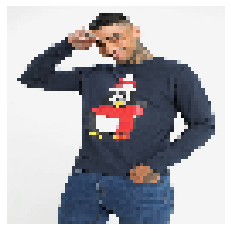

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

### Preprocessing

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 64x64x3.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [ ]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator() 

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [ ]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. [TODO: explain minimax objective function in tutorial, along with visual illustrations]

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the dcgan model, use the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** as recommended by the paper. 

In later GAN tutorials, you will learn that we can use other loss functions for other GAN variants.

In [ ]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the dcgan model!

Epoch 1/50
506/506 [==============================] - ETA: 0s - d_loss: 0.5793 - g_loss: 1.4729

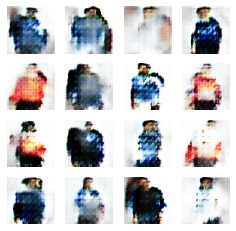

506/506 [==============================] - 93s 178ms/step - d_loss: 0.5793 - g_loss: 1.4729
Epoch 2/50
506/506 [==============================] - ETA: 0s - d_loss: 0.5941 - g_loss: 1.2753

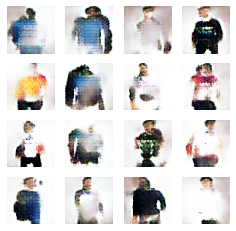

506/506 [==============================] - 92s 179ms/step - d_loss: 0.5941 - g_loss: 1.2753
Epoch 3/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6354 - g_loss: 1.1260

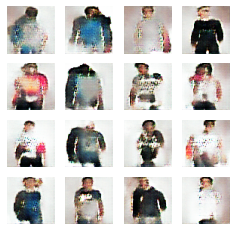

506/506 [==============================] - 123s 242ms/step - d_loss: 0.6352 - g_loss: 1.1253
Epoch 4/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6691 - g_loss: 1.0332

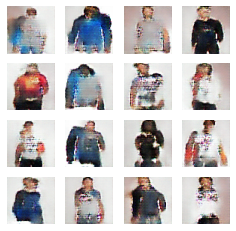

506/506 [==============================] - 93s 182ms/step - d_loss: 0.6688 - g_loss: 1.0330
Epoch 5/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6812 - g_loss: 0.9825

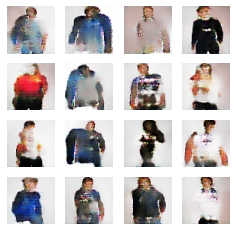

506/506 [==============================] - 94s 183ms/step - d_loss: 0.6808 - g_loss: 0.9836
Epoch 6/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6913 - g_loss: 0.9287

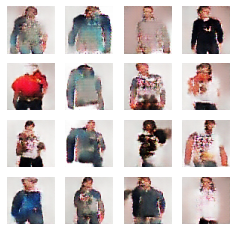

506/506 [==============================] - 94s 183ms/step - d_loss: 0.6913 - g_loss: 0.9287
Epoch 7/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6943 - g_loss: 0.8998

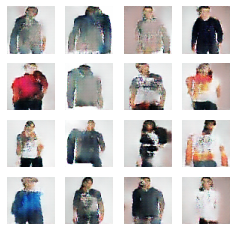

506/506 [==============================] - 95s 185ms/step - d_loss: 0.6943 - g_loss: 0.8996
Epoch 8/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6857 - g_loss: 0.8946

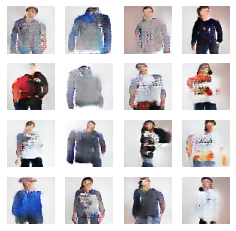

506/506 [==============================] - 95s 186ms/step - d_loss: 0.6859 - g_loss: 0.8946
Epoch 9/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6941 - g_loss: 0.8681

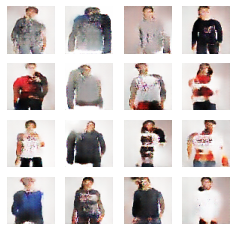

506/506 [==============================] - 95s 184ms/step - d_loss: 0.6941 - g_loss: 0.8681
Epoch 10/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6923 - g_loss: 0.8554

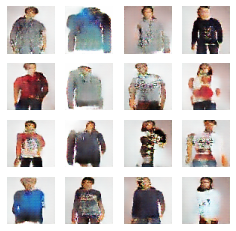

506/506 [==============================] - 96s 187ms/step - d_loss: 0.6923 - g_loss: 0.8552
Epoch 11/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6905 - g_loss: 0.8550

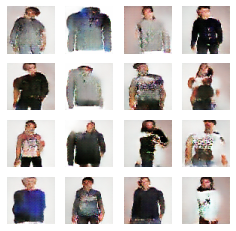

506/506 [==============================] - 96s 188ms/step - d_loss: 0.6904 - g_loss: 0.8551
Epoch 12/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6932 - g_loss: 0.8401

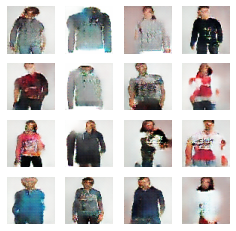

506/506 [==============================] - 97s 189ms/step - d_loss: 0.6932 - g_loss: 0.8401
Epoch 13/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6914 - g_loss: 0.8340

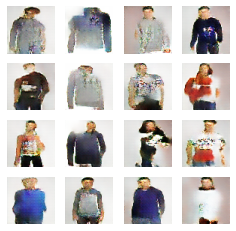

506/506 [==============================] - 97s 190ms/step - d_loss: 0.6915 - g_loss: 0.8340
Epoch 14/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6932 - g_loss: 0.8209

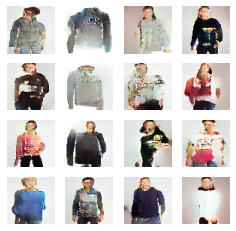

506/506 [==============================] - 98s 191ms/step - d_loss: 0.6932 - g_loss: 0.8209
Epoch 15/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6911 - g_loss: 0.8142

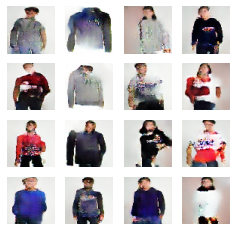

506/506 [==============================] - 98s 192ms/step - d_loss: 0.6909 - g_loss: 0.8149
Epoch 16/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6897 - g_loss: 0.8141

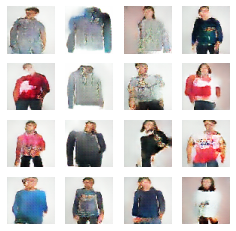

506/506 [==============================] - 99s 193ms/step - d_loss: 0.6897 - g_loss: 0.8143
Epoch 17/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6912 - g_loss: 0.8075

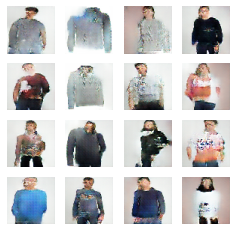

506/506 [==============================] - 99s 194ms/step - d_loss: 0.6913 - g_loss: 0.8074
Epoch 18/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6910 - g_loss: 0.8059

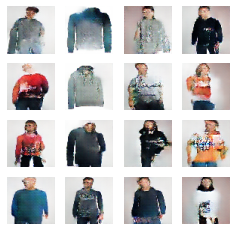

506/506 [==============================] - 100s 194ms/step - d_loss: 0.6911 - g_loss: 0.8058
Epoch 19/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6929 - g_loss: 0.7935

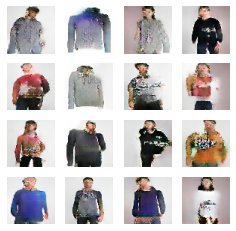

506/506 [==============================] - 100s 195ms/step - d_loss: 0.6929 - g_loss: 0.7936
Epoch 20/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6928 - g_loss: 0.7910

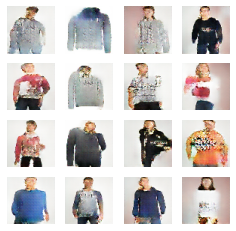

506/506 [==============================] - 100s 196ms/step - d_loss: 0.6928 - g_loss: 0.7912
Epoch 21/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6888 - g_loss: 0.7866

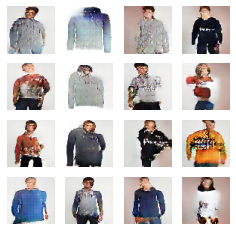

506/506 [==============================] - 101s 198ms/step - d_loss: 0.6890 - g_loss: 0.7866
Epoch 22/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6892 - g_loss: 0.7880

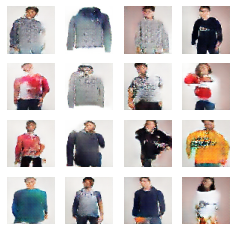

506/506 [==============================] - 101s 197ms/step - d_loss: 0.6891 - g_loss: 0.7881
Epoch 23/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6900 - g_loss: 0.7860

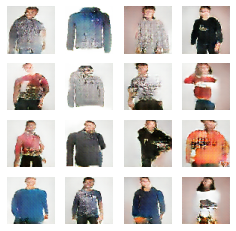

506/506 [==============================] - 102s 199ms/step - d_loss: 0.6900 - g_loss: 0.7860
Epoch 24/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6878 - g_loss: 0.7878

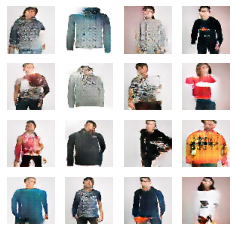

506/506 [==============================] - 102s 200ms/step - d_loss: 0.6878 - g_loss: 0.7878
Epoch 25/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6871 - g_loss: 0.7858

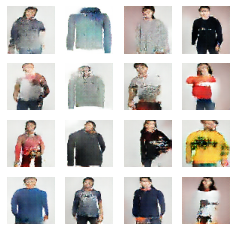

506/506 [==============================] - 103s 201ms/step - d_loss: 0.6870 - g_loss: 0.7858
Epoch 26/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6878 - g_loss: 0.7900

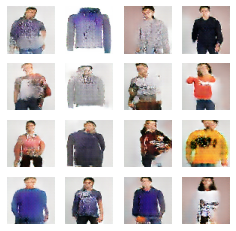

506/506 [==============================] - 103s 202ms/step - d_loss: 0.6878 - g_loss: 0.7900
Epoch 27/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6880 - g_loss: 0.7826

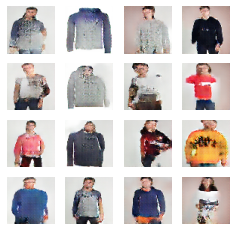

506/506 [==============================] - 103s 202ms/step - d_loss: 0.6879 - g_loss: 0.7827
Epoch 28/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6861 - g_loss: 0.7859

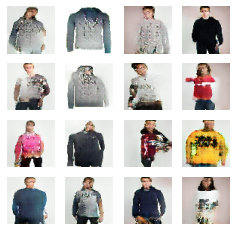

506/506 [==============================] - 104s 203ms/step - d_loss: 0.6862 - g_loss: 0.7857
Epoch 29/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6840 - g_loss: 0.7911

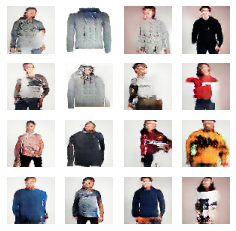

506/506 [==============================] - 105s 205ms/step - d_loss: 0.6840 - g_loss: 0.7909
Epoch 30/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6843 - g_loss: 0.7856

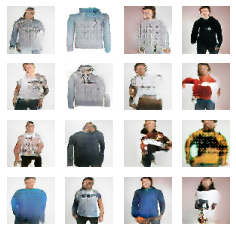

506/506 [==============================] - 105s 205ms/step - d_loss: 0.6845 - g_loss: 0.7853
Epoch 31/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6826 - g_loss: 0.7900

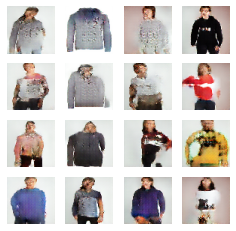

506/506 [==============================] - 106s 206ms/step - d_loss: 0.6826 - g_loss: 0.7900
Epoch 32/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6821 - g_loss: 0.7923

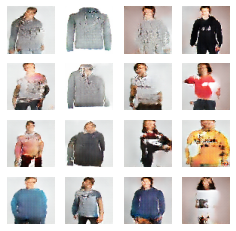

506/506 [==============================] - 106s 208ms/step - d_loss: 0.6820 - g_loss: 0.7924
Epoch 33/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6782 - g_loss: 0.7994

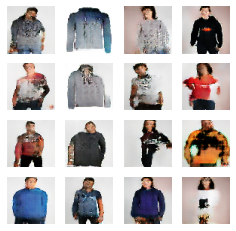

506/506 [==============================] - 107s 208ms/step - d_loss: 0.6782 - g_loss: 0.7995
Epoch 34/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6774 - g_loss: 0.8035

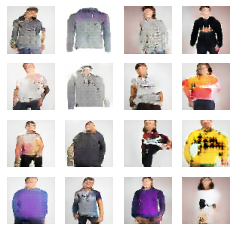

506/506 [==============================] - 107s 208ms/step - d_loss: 0.6774 - g_loss: 0.8038
Epoch 35/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6747 - g_loss: 0.8014

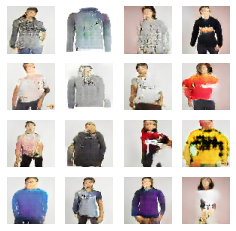

506/506 [==============================] - 107s 208ms/step - d_loss: 0.6747 - g_loss: 0.8014
Epoch 36/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6716 - g_loss: 0.8087

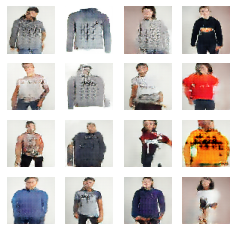

506/506 [==============================] - 108s 210ms/step - d_loss: 0.6716 - g_loss: 0.8086
Epoch 37/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6736 - g_loss: 0.8052

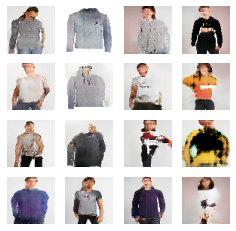

506/506 [==============================] - 107s 210ms/step - d_loss: 0.6736 - g_loss: 0.8052
Epoch 38/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6719 - g_loss: 0.8114

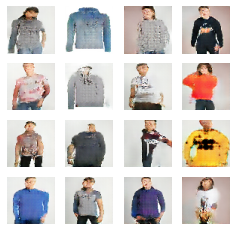

506/506 [==============================] - 108s 212ms/step - d_loss: 0.6718 - g_loss: 0.8115
Epoch 39/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6717 - g_loss: 0.8198

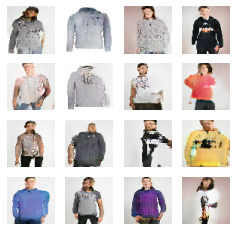

506/506 [==============================] - 108s 212ms/step - d_loss: 0.6716 - g_loss: 0.8201
Epoch 40/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6718 - g_loss: 0.8189

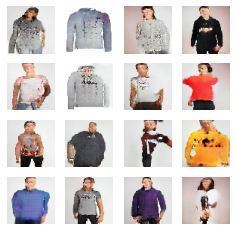

506/506 [==============================] - 109s 213ms/step - d_loss: 0.6717 - g_loss: 0.8190
Epoch 41/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6664 - g_loss: 0.8224

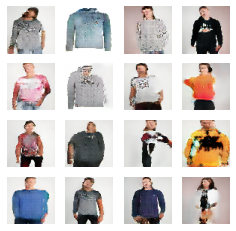

506/506 [==============================] - 109s 213ms/step - d_loss: 0.6664 - g_loss: 0.8225
Epoch 42/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6654 - g_loss: 0.8299

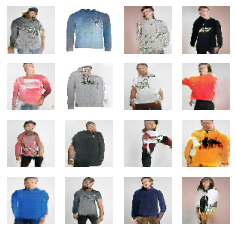

506/506 [==============================] - 110s 215ms/step - d_loss: 0.6654 - g_loss: 0.8298
Epoch 43/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6677 - g_loss: 0.8238

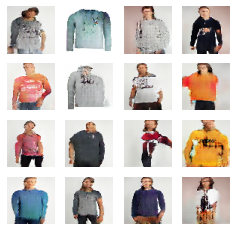

506/506 [==============================] - 110s 215ms/step - d_loss: 0.6677 - g_loss: 0.8238
Epoch 44/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6658 - g_loss: 0.8364

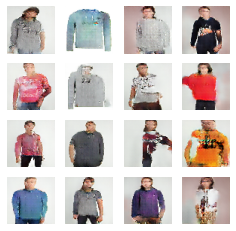

506/506 [==============================] - 109s 213ms/step - d_loss: 0.6658 - g_loss: 0.8364
Epoch 45/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6612 - g_loss: 0.8389

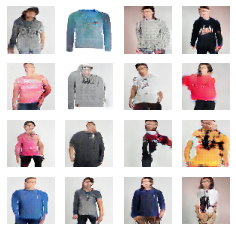

506/506 [==============================] - 107s 209ms/step - d_loss: 0.6612 - g_loss: 0.8389
Epoch 46/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6636 - g_loss: 0.8406

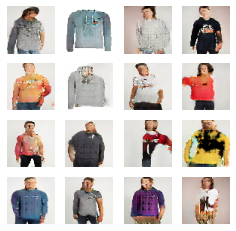

506/506 [==============================] - 108s 211ms/step - d_loss: 0.6636 - g_loss: 0.8404
Epoch 47/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6611 - g_loss: 0.8459

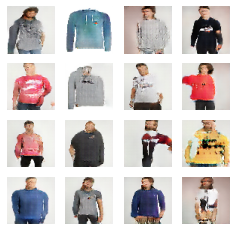

506/506 [==============================] - 109s 213ms/step - d_loss: 0.6610 - g_loss: 0.8460
Epoch 48/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6564 - g_loss: 0.8519

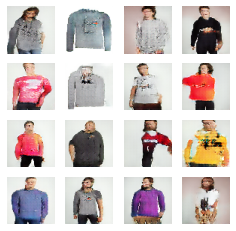

506/506 [==============================] - 108s 212ms/step - d_loss: 0.6564 - g_loss: 0.8519
Epoch 49/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6568 - g_loss: 0.8565

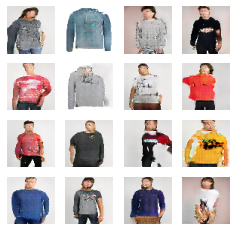

506/506 [==============================] - 110s 215ms/step - d_loss: 0.6568 - g_loss: 0.8569
Epoch 50/50
505/506 [============================>.] - ETA: 0s - d_loss: 0.6550 - g_loss: 0.8633

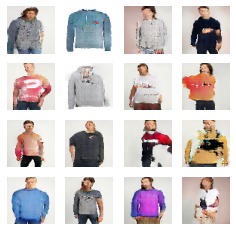

506/506 [==============================] - 110s 215ms/step - d_loss: 0.6550 - g_loss: 0.8633


In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])